<a href="https://colab.research.google.com/github/CodyBurker/W266_Group_Project/blob/CodyCNNBase/CodyCNNAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [65]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import numpy as np

In [66]:
!git clone https://github.com/CodyBurker/W266_Group_Project

fatal: destination path 'W266_Group_Project' already exists and is not an empty directory.


In [67]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_sampled_yelp_data.csv")
    y_train = pd.read_csv(path + "y_train_sampled_yelp_data.csv")
    X_test = pd.read_csv(path + "x_test_sampled_yelp_data.csv")
    y_test = pd.read_csv(path + "y_test_sampled_yelp_data.csv")
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = read_in_data()
y_train = np.array(y_train.stars.astype('int')) - 1
y_test = np.array(y_test.stars.astype('int')) - 1

https://towardsdev.com/sentiment-analysis-with-cnn-using-keras-c4debff57fc5?gi=708b4ef40e2f

Encode text and pad it.

In [69]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])


In [71]:
X_train['encoded'] = tokenizer.texts_to_sequences(X_train['text'])
X_test['encoded'] = tokenizer.texts_to_sequences(X_test['text'])

(array([47936., 21142.,  6699.,  2360.,   947.,   441.,   202.,   134.,
           90.,    49.]),
 array([   0.,  101.,  202.,  303.,  404.,  505.,  606.,  707.,  808.,
         909., 1010.]),
 <a list of 10 Patch objects>)

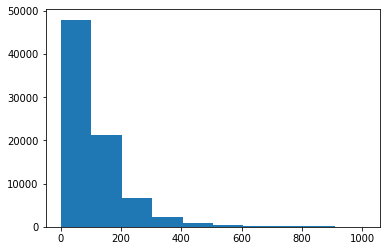

In [72]:
import matplotlib.pyplot as plt
plt.hist(X_train['encoded'].apply(len))

In [73]:
# Hyper parameters to tune later: maxlen, padding
sentence_len = 200
X_train_encoded =  pad_sequences(X_train['encoded'], maxlen=sentence_len, padding='post', truncating='post')
X_test_encoded = pad_sequences(X_test['encoded'], maxlen=sentence_len, padding='post', truncating = 'post')
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(80000, 200)
(20000, 200)


Create model

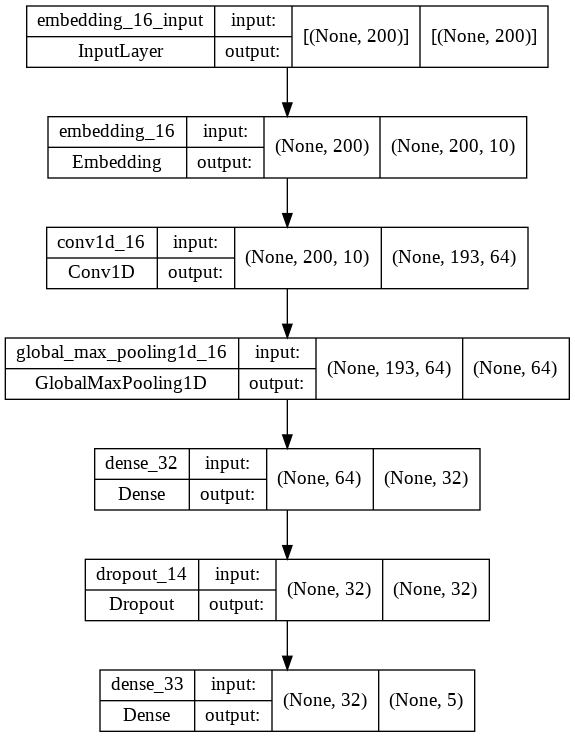

In [120]:
from keras.layers.pooling import GlobalMaxPool1D
# New model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size,10, input_length = sentence_len))
model2.add(Conv1D(64,8,activation="relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(5,activation='softmax'))
# model2.add(Dense(1,activation='relu'))
from keras.utils.vis_utils import plot_model
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model2,show_shapes=True)


In [122]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

history = model2.fit(X_train_encoded,y_train,
           epochs=150,
           batch_size=128, 
           validation_data = [X_test_encoded, y_test],
           callbacks = [callback])

Epoch 1/150
625/625 [==============================] - 4s 6ms/step - loss: 1.4180 - accuracy: 0.4417 - val_loss: 1.4116 - val_accuracy: 0.4443
Epoch 2/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4162 - accuracy: 0.4417 - val_loss: 1.4090 - val_accuracy: 0.4443
Epoch 3/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4140 - accuracy: 0.4417 - val_loss: 1.4067 - val_accuracy: 0.4443
Epoch 4/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4126 - accuracy: 0.4417 - val_loss: 1.4049 - val_accuracy: 0.4443
Epoch 5/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4107 - accuracy: 0.4417 - val_loss: 1.4025 - val_accuracy: 0.4443
Epoch 6/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4085 - accuracy: 0.4417 - val_loss: 1.3998 - val_accuracy: 0.4443
Epoch 7/150
625/625 [==============================] - 2s 3ms/step - loss: 1.4060 - accuracy: 0.4423 - val_loss: 1.3958 - val_accuracy: 0.4443

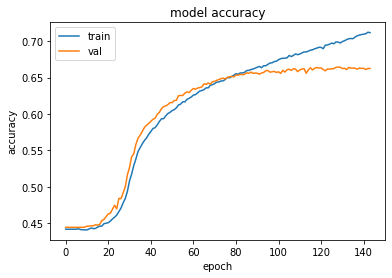

In [124]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

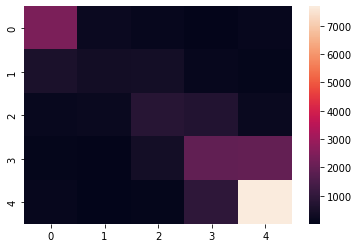

In [139]:
# Generate confusion matrix on test set
test_preds = model2.predict(X_test_encoded)
test_preds_stars = test_preds.argmax(axis=1) + 1
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test + 1, test_preds_stars)
import seaborn as sns
sns.heatmap(cf)

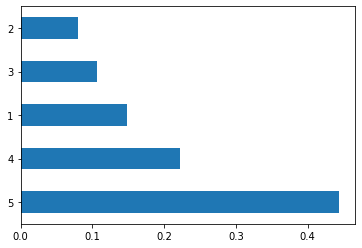

In [153]:
y_test_pd = pd.DataFrame({'stars':y_test})
y_test_pd.stars = y_test_pd.stars + 1
# freq = y_test_pd.groupby(['stars']).size()
(y_test_pd.stars.value_counts() / len(y_test_pd)).plot.barh()